# Spectral Botany proof of concept

By Tim Hackwood

This Notebook demonstrates techniques for creating spectral species over the Brigalow Belt bioregion in Queensland, Australia and how they may be used to model the distribution of plant species with multispectral remote sensing data.

Methodology for raster segmentation and clustering adapted from Peter Scarth (2022) https://github.com/petescarth/segmentation-example, with pyshepseg https://github.com/ubarsc/pyshepseg leveraged to segment the large dataset.

In [1]:
# Imports
from rios import applier, cuiprogress
import pickle
import geopandas as gpd
from tqdm import tqdm
from shapely import box
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
import os
import galah
from osgeo import gdal, ogr, gdalconst, osr
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import joblib
from rios import rat
from rios import applier, cuiprogress
from rios import ratapplier
from pyshepseg import tiling
from pyshepseg import tilingstats
from pyshepseg import utils
from pystac_client import Client
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import folium
from skimage import exposure
import shapely.geometry
import branca
import glob
import numpy as np

# Set the working directory to SpectralBotany
os.chdir("/home/tim/rubella/scripts/SpectralBotany")

# Config for Atlas Living Australia APO
galah.galah_config(email = "timothy.hackwood@gmail.com", atlas = "Australia")

AOI = "data/SpectralBotanyTest.gpkg"
Layer = "BrigalowBeltAOI"

# FIles for PCA and Segment outputs
RASTER_PC = "data/Sentinel/Sentinel_brigalow_PCA_e24.tif"
RASTER_SEG = RASTER_PC.replace(".tif", "_segs.kea")

<Axes: >

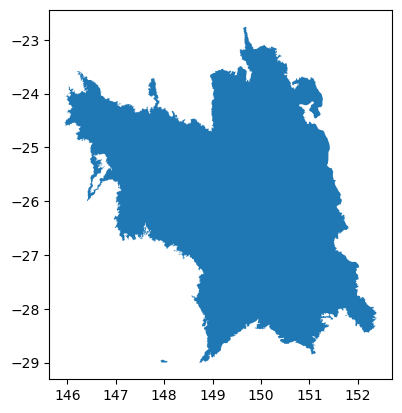

In [2]:
# Load AOI
brigalow = gpd.read_file(AOI, layer=Layer)
# Reproject to WGS84 for STAC API
brigalow.to_crs(4326, inplace=True)
# Plot to check everything looks ok
brigalow.plot()

## Plotting functions

In [28]:
def plot_rgb_to_html(input_tif, output_html, zoom=8, nodata=0, bandorder=[1, 2, 3], show=True):
    """
    Warp tif to wgs84, normalize data and stretch autimatically, and create a folium map with the raster overlay 
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first three bands
        data = src.read(bandorder).astype(np.float32)
        # Identify the no-data values
        no_data_mask = np.all(data == nodata, axis=0)
        # Normalize data to [0, 1] for each band before applying CLAHE
        data_normalized = np.array([exposure.rescale_intensity(band, in_range=(band.min(), band.max()), out_range=(0, 1)) for band in data])
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = np.array([exposure.equalize_adapthist(band, clip_limit=0.03) for band in data_normalized])
        # Reshape data for plotting
        data = reshape_as_image(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data = np.dstack((data, alpha_channel))
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom)

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

In [29]:
def plot_thematic_to_html(input_tif, output_html, zoom=8, nodata=0, cmap='viridis', legend_range=None, show=False):
    """
    Warp tif to wgs84, normalize data and stretch automatically, and create a folium map with the raster overlay.
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first band
        data = src.read(1).astype(np.float32)
        # Identify the no-data values
        no_data_mask = (data == nodata)
        # Apply quantile stretch only to non no-data values
        valid_data = data[~no_data_mask]
        p2, p98 = np.percentile(valid_data, (2, 98))
        data_stretched = exposure.rescale_intensity(data, in_range=(p2, p98), out_range=(0, 1))
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = exposure.equalize_adapthist(data_stretched, clip_limit=0.03) 
        # Apply colormap
        cmap = plt.get_cmap(cmap)
        data_colored = cmap(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data_colored[..., -1] = alpha_channel
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom,
                   )

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data_colored,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Determine legend range
    legend_min = legend_range[0] if legend_range else p2
    legend_max = legend_range[1] if legend_range else p98

    # Add a legend
    colormap = branca.colormap.LinearColormap(
        colors=[cmap(i) for i in range(cmap.N)],
        vmin=legend_min,
        vmax=legend_max,
        caption='Legend'
    )
    colormap.add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

## Get Landsat data if needed

In [ ]:
# Function to build vrt by band from DEA files on STAC API for each band
def buildVRT(tiles, dir):

    # List of the band names to stack in the VRT
    BandNames = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    vrtList = []

    # Make a full timeseries vrt with each band
    for band in BandNames:
        vrtName = band + '_.vrt'
        vrt = os.path.join(dir, vrtName)
        vrtList.append(vrt)
        urlList = []
        for item in tiles:
            # Get the url for the band
            url = item.assets[band].href
            # Add it to the list
            urlList.append(url.replace(
                's3://',
                '/vsis3/'))
        # Set options for the VRT file
        vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                        separate=False,
                                        resolution='highest',
                                        VRTNodata=-999)

        # Then make the VRT file using the list of URLs
        vrtData = gdal.BuildVRT(vrt,
                                urlList,
                                options=vrtOptions)
        
        # Close the VRT file
        vrtData = None

    return vrtList

In [ ]:
# Get landsat-8 data (using DEA barest-earth)
brigalow.to_crs(4326, inplace=True)
bbox = brigalow.total_bounds

# STAC querey
client = Client.open("https://explorer.sandbox.dea.ga.gov.au/stac")
s2Search = client.search(
    bbox=bbox,
    collections=['ls8_barest_earth_albers'],
)
# Show the results of the search
print(f"{s2Search.matched()} items found")

tiles = s2Search.item_collection()

# Build the virtual mosaic for each band
print("Building virtual band mosaics")
vrtList = buildVRT(tiles, 'data/Landsat')

vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                separate=True,
                                resolution='highest',
                                VRTNodata=-999)
print("Stacking bands")
vrtData = gdal.BuildVRT('data/Landsat/LandsatBarest_brigalow.vrt',
                        vrtList,
                        options=vrtOptions)

# Close the VRT file
vrtData = None


In [ ]:
# Make a 250m resampled image for this demonstration
Landsat = "data/Landsat/LandsatBarest_brigalow.vrt".replace(".vrt", "_250m.tif")
gdal.Warp(Landsat, "data/Landsat/LandsatBarest_brigalow.vrt", xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

In [ ]:
# Export landsat to a web map
plot_rgb_to_html(Landsat, "LandsatBarest_brigalow.html", zoom=8, nodata=-999, bandorder=[3, 2, 1])

## Stack with indices and get PCA for segmentation

The 6 Landsat bands are stacked with NDVI and NDWI indices. For future versions, other indicies and timeseries data would be good to add in.

A PCA tiff is produced based on this data stack, then segmented.

In [15]:
# New version using seasonal Sentinel 2
import glob

def all_ratios(sampleData):
    numBands = sampleData.shape[0]
    clippedData = np.clip(sampleData, 0, None).astype(float)
    # Get indices of upper triangle of the array
    i, j = np.triu_indices(numBands, 1)
    # Calculate the ratio of each band to every other band
    ratio_arr = (clippedData[i]-clippedData[j])/(clippedData[i]+clippedData[j]+np.finfo(float).eps)
    # Concatenate sampleData and reshaped ratio_arr
    sampleData = np.concatenate((sampleData,ratio_arr.reshape((-1,) + sampleData.shape[1:])), axis=0)
    
    return sampleData

# Calculate the bounding box of brigalow (Landsat imagery is in Albers)
brigalow.to_crs(epsg=3577, inplace=True)
bbox = brigalow.total_bounds

indata = []

images = ["/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202309202311_abma2_brig.tif"] # "/home/tim/dentata/outputs/brigalow_ndvistats.tif", "/home/tim/dentata/outputs/brigalow_ndwistats.tif"] # reflectance and ndvi/ndwi stats

for rast in images:
    with rasterio.open(rast) as src:
        
        # Open a subsampled version of the image
        out_height = int(src.height / 50)
        out_width = int(src.width / 50)

        # Read the subsampled data from src using the bounding box
        img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
        img = all_ratios(img)
        inshape = img.shape
        
        print(inshape)
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        indata.append(stack)
        
datastack = np.vstack(indata)

print(datastack.shape)

# # Calculate the mean and std across all images (axis 0) for each band
# mean_bands = np.mean(datastack, axis=0)
# std_bands = np.std(datastack, axis=0)

# # Stack the mean and std arrays to form a new data stack
# new_datastack = np.concatenate([mean_bands, std_bands], axis=0)


# print(new_datastack.shape)

# get mean and std for each band datastack



(21, 1391, 1153)
(23, 1391, 1153)


In [ ]:
# Make a subsampled dataset of multispectral imagery for PCA
with rasterio.open("/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202312202402_abma2.vrt") as src:
    # Calculate the bounding box of brigalow (Landsat imagery is in Albers)
    brigalow.to_crs(epsg=3577, inplace=True)
    bbox = brigalow.total_bounds
    # Open a subsampled version of the image
    out_height = int(src.height / 50)
    out_width = int(src.width / 50)

    # Read the subsampled data from src using the bounding box
    img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
    inshape = img.shape
    print(inshape)
    

In [16]:
# Get indicies and fit the PCA

N_COMPONENTS = 3 # Change depending on variance.

# Calculate NDVI/NDWI, stack and scale
# Landsat-8 bands - TERN Sentinel 2 seasonal surface reflectance is the same as landsat 8
ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])

    
# # Stack these ratios with the original data
# stack = np.vstack([img, ndvi, ndwi])
# print(stack.shape)

# Reshape stack for scaling
scale = np.reshape(datastack, (datastack.shape[0], -1))



# Delete unneeded variables
del img
del ndvi
del ndwi

# Rescale with robust scaler    
scaler = RobustScaler()
stack_scale = scaler.fit_transform(scale.T)
# Save the scaler
joblib.dump(scaler, './stack_scaler.pkl')
print(stack_scale.shape)

del scale

# Fit the PCA
pca = PCA(n_components=N_COMPONENTS, svd_solver='full', whiten=True)
pca.fit(stack_scale)
# Print the variance and save the PCA
sumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained: {sumvar}")
joblib.dump(pca, './pca.pkl')

# Transform the data to byte scale and save
pcaData = pca.transform(stack_scale).T
byteScale = np.percentile(pcaData,[0.001,99.999],axis=1)
joblib.dump(byteScale, './byteScale.pkl')

(1603823, 23)
Variance explained: [0.62552819 0.92999157 0.9683445 ]


['./byteScale.pkl']

In [17]:
# Apply the PCA to the full image and mask to Brigalow AOI
# Takes ~20 minutes
def _applyPCA(info, inputs, outputs, otherargs):
    """
    Apply PCA to full resolution dataset.
    """
    # Open the images
    s2 = inputs.inlist
    inshape = s2[0].shape
    aoi = inputs.aoi
    # nodata = np.any(s2[0] == 0, axis=0)

    datastack = []

    for img in s2:

        img = all_ratios(img)
        
        inshape = img.shape        
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        datastack.append(stack)
            
    stack = np.vstack(datastack)

    # Calculate the mean and std across all images (axis 0) for each band
    # mean_bands = np.mean(datastack, axis=0)
    # std_bands = np.std(datastack, axis=0)
    # stdOut = 10000 * 10000 + std_bands
    # print(stdOut.shape)
    # stdOut[:, np.any(nodata)] = 0
    # outputs.ndviSD = stdOut.astype(np.uint16)

    # # Stack the mean and std arrays to form a new data stack
    # stack = np.concatenate([mean_bands, std_bands], axis=0)

    scaled_stack = np.reshape(stack, (stack.shape[0], -1)).astype('float32').T

    # Apply the PCA    
    pc = otherargs.pca.transform(otherargs.scaler.transform(scaled_stack))
    # Rescale to 16bit
    pc = np.round(np.clip(1.0 + 65534.0
                        * (pc-otherargs.bytescale[0])
                        / (otherargs.bytescale[1]-otherargs.bytescale[0])
                        ,1,65535))
        
    # Reshape the output
    pc = np.reshape(pc.T,(pc.shape[1],inshape[1],inshape[2]))
    # Mask the output for no data

    pc[:,np.any(stack == otherargs.noData,axis=0)] = 0
    pc[:, np.any(aoi == 0, axis=0)] = 0 # mask to the AOI
    outputs.pc =  pc.astype(np.uint16)

# Get the no data value
ds = gdal.Open("/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202109202111_abma2.vrt")
noData = ds.GetRasterBand(1).GetNoDataValue()
    
# Create the RIOS file objects
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

# Setup the IO
infiles.inlist = ["/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202309202311_abma2_brig.tif"]
infiles.aoi = "data/SpectralBotanyTest.gpkg"

outfiles.pc = RASTER_PC
# outfiles.ndviSD = "./NDVI_SD"

# Get the otherargs
otherargs = applier.OtherInputs()
otherargs.pca = joblib.load("pca.pkl")
otherargs.scaler = joblib.load("stack_scaler.pkl")
otherargs.bytescale = joblib.load("byteScale.pkl")
otherargs.noData = noData

# Controls for the processing   
controls = applier.ApplierControls()
controls.vectorlayer = "BrigalowBeltAOI"
controls.setBurnValue = 1
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(0) #  nodata
controls.progress = cuiprogress.CUIProgressBar()
controls.setFootprintType("INTERSECTION")
controls.setResampleMethod("near")
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                                "ZLEVEL=9",
                                "PREDICTOR=2",
                                "BIGTIFF=YES",
                                "TILED=YES",
                                "INTERLEAVE=BAND",
                                "NUM_THREADS=ALL_CPUS",
                                "BLOCKXSIZE=512",
                                "BLOCKYSIZE=512"])

# Set concurrency depending on system
conc = applier.ConcurrencyStyle(numReadWorkers=3,
                                numComputeWorkers=2,
                                computeWorkerKind="CW_THREADS",
                                readBufferPopTimeout=120,
                                computeBufferPopTimeout=120
                                )

controls.setConcurrencyStyle(conc)

# Run the function
print("Processing PCA")
applier.apply(_applyPCA, infiles, outfiles, otherargs, controls=controls)   

Processing PCA

Computing Pyramid Layers...

Computing Statistics...


In [ ]:
# Make a 250m resampled image for this demonstration
PCA_250m = RASTER_PC.replace(".tif", "_250m.tif")
gdal.Warp(PCA_250m, RASTER_PC, xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

In [ ]:
# plot the result to a slippy map
plot_rgb_to_html(PCA_250m, "PCA_250m.html", zoom=8, show=True)


## Segment the PCA to get Spectral Species 

This segmentation method uses a tiled version of Shepard segmentation and is great for larger dataset as the data are chunked into managable sizes before being stitched back together.

Shepard segmentation is based on k-means clustering and seems functionally identical to methods used for spectral species extraction.

In [ ]:
# Get NDVI and NDMI distributions to add into spatial statistics
def indexDist(vrtList):

    ndvistack = []
    ndwistack = []

    for img in vrtList:

        inshape = img.shape
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        ndvistack.append(ndvi)
        ndwistack.append(ndwi)
            
    ndvistack = np.stack(ndvistack, axis=0)
    ndwistack = np.stack(ndwistack, axis=0)

    # Get new stack with 5th, 25th, 50th, 75th and 95th percentiles
    ndviStats = np.percentile(ndvistack, [5, 25, 50, 75, 95], axis=0)
    ndwiStats = np.percentile(ndwistack, [5, 25, 50, 75, 95], axis=0)

    return ndviStats, ndwiStats

        

In [19]:
SEGMENT_SIZE = 100 # Approximately 1 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 3 # Number of PCA components

NDVI =  "/home/tim/dentata/outputs/brigalow_ndvistats.tif"
NDWI = "/home/tim/dentata/outputs/brigalow_ndwistats.tif"


# Segment using the tiled version
print('Segmenting')
tiledSegResult = tiling.doTiledShepherdSegmentation(RASTER_PC, RASTER_SEG,
            minSegmentSize=SEGMENT_SIZE, numClusters=512,
            bandNumbers=None, subsamplePcnt=None,
            maxSpectralDiff='auto', spectDistPcntile=25,
            imgNullVal=0, fourConnected=True, verbose=True,
            simpleTileRecode=False, outputDriver='KEA', kmeansObj=None)
           
# Do histogram, stats and colour table on final output file.
print('Adding Histogram, Stats and Colour Table')
outDs = gdal.Open(RASTER_SEG, gdal.GA_Update)
hist = tiling.calcHistogramTiled(outDs, tiledSegResult.maxSegId, writeToRat=True)
band = outDs.GetRasterBand(1)
utils.estimateStatsFromHisto(band, hist)
utils.writeRandomColourTable(band, tiledSegResult.maxSegId+1)
del outDs

# Add the original Image Stats
print('Adding Image Stats')
for imgbandnum in range(1,N_COMPONENTS+1):
    statsSelection = [
        ('pca_Band_{}_mean'.format(imgbandnum), 'mean'),
        ('pca_Band_{}_std'.format(imgbandnum), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(RASTER_PC, imgbandnum, RASTER_SEG,statsSelection)

# Add the index stats
print('Adding NDVI Stats')
ndvistats = ["median", "stddev", "5th", "25th", "75th", "95th"]
for i, statband in enumerate(ndvistats):
    statsSelection = [
        ('ndvi_{}_mean'.format(statband), 'mean'),
        ('ndvi_{}_std'.format(statband), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(NDVI, i+1, RASTER_SEG,statsSelection)
    
# Add the index stats
print('Adding NDWI Stats')
ndwistats = ["median", "stddev", "5th", "25th", "75th", "95th"]
for i, statband in enumerate(ndwistats):
    statsSelection = [
        ('ndWi_{}_mean'.format(statband), 'mean'),
        ('ndWi_{}_std'.format(statband), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(NDWI, i+1, RASTER_SEG,statsSelection)
    

# Export the segmentation as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.id = RASTER_SEG.replace('.kea', '_id.tif')
outfiles.rgb = RASTER_SEG.replace('.kea', '_rgb.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.round(rat.readColumn(infiles.image, f'pca_Band_{i}_mean')).astype(np.uint16))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    outputs.id = data.reshape((1,) + inputs.image.shape[1:]).astype(np.uint32)
    outputs.rgb = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Segmenting
Starting tiled segmentation
KMeans of whole raster 206.38 seconds
Subsample Percentage=0.02
Found 378 tiles, with 21 rows and 18 cols

Doing tile 1 of 378: row=0, col=0
Kmeans, in 3.6 seconds
Found 0 clumps, in 0.7 seconds
Eliminated 0 single pixels, in 1.9 seconds
Eliminated 0 segments, in 2.0 seconds
Final result has 0 segments

Doing tile 2 of 378: row=0, col=1
Kmeans, in 3.4 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 3 of 378: row=0, col=2
Kmeans, in 3.4 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 4 of 378: row=0, col=3
Kmeans, in 3.5 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 5 of 378: row=0, col=4
Kmeans, in 3.4 seconds
Found

In [20]:
# Sava a copy of the segmentation
print('Saving a copy of the segmentation')
os.system('cp {} {}'.format(RASTER_SEG, RASTER_SEG.replace('.kea','.orig.kea')))

Saving a copy of the segmentation


0

In [7]:
gdal.Info(RASTER_SEG)

'Driver: KEA/KEA Image Format (.kea)\nFiles: data/Sentinel/Sentinel_brigalow_PCA_v2_segs.kea\nSize is 57678, 69598\nCoordinate System is:\nPROJCRS["GDA94 / Australian Albers",\n    BASEGEOGCRS["GDA94",\n        DATUM["Geocentric Datum of Australia 1994",\n            ELLIPSOID["GRS 1980",6378137,298.257222101,\n                LENGTHUNIT["metre",1]]],\n        PRIMEM["Greenwich",0,\n            ANGLEUNIT["degree",0.0174532925199433]],\n        ID["EPSG",4283]],\n    CONVERSION["unnamed",\n        METHOD["Albers Equal Area",\n            ID["EPSG",9822]],\n        PARAMETER["Latitude of false origin",0,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8821]],\n        PARAMETER["Longitude of false origin",132,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8822]],\n        PARAMETER["Latitude of 1st standard parallel",-18,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8823]],\n        PARAMETER["Latitu

In [21]:
# Get coefficient of variation for each PCA band

def variation(info, inputs, outputs):
    outputs.vegclass.pca1_var = np.where(inputs.vegclass.pca_Band_1_mean > 0, inputs.vegclass.pca_Band_1_std  / inputs.vegclass.pca_Band_1_mean, 0)
    outputs.vegclass.pca2_var = np.where(inputs.vegclass.pca_Band_2_mean > 0, inputs.vegclass.pca_Band_2_std  / inputs.vegclass.pca_Band_2_mean, 0)
    outputs.vegclass.pca3_var = np.where(inputs.vegclass.pca_Band_3_mean > 0, inputs.vegclass.pca_Band_3_std  / inputs.vegclass.pca_Band_3_mean, 0)

inRats = ratapplier.RatAssociations()
outRats = ratapplier.RatAssociations()

inRats.vegclass = ratapplier.RatHandle(RASTER_SEG)
outRats.vegclass = ratapplier.RatHandle(RASTER_SEG)

ratapplier.apply(variation, inRats, outRats)


/tmp/ipykernel_1886314/1695939303.py:4: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca1_var = np.where(inputs.vegclass.pca_Band_1_mean > 0, inputs.vegclass.pca_Band_1_std  / inputs.vegclass.pca_Band_1_mean, 0)
/tmp/ipykernel_1886314/1695939303.py:5: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca2_var = np.where(inputs.vegclass.pca_Band_2_mean > 0, inputs.vegclass.pca_Band_2_std  / inputs.vegclass.pca_Band_2_mean, 0)
/tmp/ipykernel_1886314/1695939303.py:6: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca3_var = np.where(inputs.vegclass.pca_Band_3_mean > 0, inputs.vegclass.pca_Band_3_std  / inputs.vegclass.pca_Band_3_mean, 0)


In [22]:
N_COMPONENTS = 3 # Number of PCA components
# Export the segmentation as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', '_var.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.array(rat.readColumn(infiles.image, f'pca{i}_var')).astype(np.float32))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    rgb = rgb * 10000
    outputs.var = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation


In [7]:
minval = np.min(vals)
maxval = np.max(vals)

print(minval, maxval)

0.0 2.2515163678477084


In [16]:
positive = vals[vals > 0]
print(len(positive))

11643886


## Get elevation stats for segments

In [ ]:
GlobalDEM = "/home/tim/rubella/scripts/build-biome/aus_v1/biome_SEG/glo-30.vrt"



## Cluster the segments based on segment mean and std reflectance

Note: This next step exracts the 'Spectral Species', however for this analysis,
the segments from the previous step will be used instead.

To determine a 'good' number of clusters, the silhouette score for 10-256 clusters will be computed. In practice, something like aglomerative clustering may produce better results.

In [ ]:
# Use K-means to cluster the segments. This would be a categorical predictor for a SDM

wantedAttributes = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean', 'pca_Band_3_std', 'pca_Band_4_mean', 'pca_Band_4_std']

# Read the data into an array
clusterData  = np.transpose([rat.readColumn(RASTER_SEG,name) for name in wantedAttributes])

# Drop the first row, as it contains the nodata
clusterData = clusterData[1:]

# Scale the data
clusterData = RobustScaler().fit_transform(clusterData)

# Sample the data to reduce the number of points
MAX_TESTING_POINTS = 2000000 # In practice, a much larger sample size would be used
sampleSize = min(MAX_TESTING_POINTS,clusterData.shape[0])
sampleIdx = np.random.choice(clusterData.shape[0],sampleSize,replace=False)

maxClusters = 30

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

def minibatch_kmeans_elbow(X, max_clusters=10, batch_size=100):
    # Compute the total inertia (inertia with 1 cluster) for explained variance calculation
    total_inertia = MiniBatchKMeans(n_clusters=1, batch_size=batch_size, random_state=42).fit(X).inertia_

    # List to store the explained variance percentages
    explained_variance_percent = []

    # Loop over the number of clusters
    for k in tqdm(range(1, max_clusters + 1), desc='Finding optimal number of clusters'):
        # Initialize MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42)
        
        # Fit the model
        kmeans.fit(X)
        
        # Calculate explained variance percentage
        variance_explained = 1 - (kmeans.inertia_ / total_inertia)
        explained_variance_percent.append(variance_explained * 100)

    # Plot the elbow curve for explained variance
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, max_clusters + 1), explained_variance_percent, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Explained Variance (%)')
    plt.title('Elbow Method using Explained Variance')
    plt.grid(True)
    plt.show()
    
    return explained_variance_percent

# Example usage:
# X is your dataset as a NumPy array or Pandas DataFrame
variance = minibatch_kmeans_elbow(clusterData[sampleIdx], max_clusters=maxClusters)



# # Find the optimal number of clusters
# inertia = []
# silhouette = []
# nclasses = range(10,256)
# for c in tqdm(nclasses, desc='Finding optimal number of clusters'):
#     kmeans = MiniBatchKMeans(n_clusters=c).fit(clusterData[sampleIdx])
#     inertia.append(kmeans.inertia_)
#     silhouette.append(silhouette_score(clusterData[sampleIdx], kmeans.labels_))

# # Find top 5 number of classes and silhouette score
# top5 = np.argsort(silhouette)[::-1][:5]
# print(f"Top 5 number of classes: {np.array(nclasses)[top5]}")

# # Plot the silhouette score
# plt.figure(figsize=(12,4))
# plt.plot(nclasses, silhouette)
# plt.grid()
# plt.title('Clustering silhouette score')
# plt.xlabel('Number of clusters')

In [6]:
# Cluster the data using K-means and write to a csv with other Segment columns
OPTIMAL_NUM_CLUSTERS = 30
# Cluster the full dataset
kmeans = MiniBatchKMeans(n_clusters = OPTIMAL_NUM_CLUSTERS).fit(clusterData)
# Get the cluster labels and add one to avoid zero values
clusterLabels = kmeans.labels_ + 1
# Add back in the first row of nodata
clusterLabels = np.insert(clusterLabels,0,0)

# Write cluster labels to kea
rat.writeColumn(RASTER_SEG, f'clust{OPTIMAL_NUM_CLUSTERS}', np.insert(kmeans.labels_ + 1, 0, 0))

# Write to .csv
# Get the column names
colNames = rat.getColumnNames(RASTER_SEG)
# Read the data into an array
allData = np.transpose([rat.readColumn(RASTER_SEG, name) for name in colNames])
# Add an index column
allData = np.vstack((np.arange(len(allData)),allData.T)).T
# Add the kmeans labels
allData = np.vstack((allData.T,clusterLabels)).T
# Make a header
colNames.insert(0,'segid')
colNames.append('kmeans_label')
header = ','.join(colNames)
# Write the file
np.savetxt(RASTER_SEG.replace(".kea", ".csv"),allData,fmt='%8.3f',delimiter=',',header=header,comments='')

In [ ]:
#  Depending on data sharing, a new Geopackage could be created with the segmentation polygons

# Append the segmentation to an existing Geopackage
outDs = gdal.Open(RASTER_SEG.replace(".kea", "_id.tif"))
band = outDs.GetRasterBand(1) # Band 1 is the segment ids
# Open the existing vector datasource
vecDs = ogr.Open(AOI, 1)  # 1 means it's opened in update mode
# Create a new layer in the existing geopackage
vecLayer = vecDs.CreateLayer('BrigalowSegID', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))
# Polygonize
vecDs.StartTransaction()
gdal.Polygonize(band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()

del outDs
del vecDs

In [ ]:
# Write the segmentation to a new Geopackage

# Write to .csv
# Get the column names
colNames = rat.getColumnNames(RASTER_SEG)
# Read the data into an array
allData = np.transpose([rat.readColumn(RASTER_SEG, name) for name in colNames])
# Add an index column
allData = np.vstack((np.arange(len(allData)),allData.T)).T
# Add the kmeans labels
# Make a header
colNames.insert(0,'segid')
header = ','.join(colNames)
# Write the file
np.savetxt(RASTER_SEG.replace(".kea", ".csv"),allData,fmt='%8.3f',delimiter=',',header=header,comments='')

segDS = RASTER_SEG.replace(".kea", "_segid.gpkg")

outDs = gdal.Open(RASTER_SEG.replace(".kea", "_id.tif"))
band = outDs.GetRasterBand(1)  # Band 1 is the segment ids

# Create a new vector datasource
driver = ogr.GetDriverByName("GPKG")
if os.path.exists(segDS):
    driver.DeleteDataSource(segDS)
vecDs = driver.CreateDataSource(segDS)

# Create a new layer in the new geopackage
vecLayer = vecDs.CreateLayer('BrigalowSegID', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))

# Polygonize
vecDs.StartTransaction()
gdal.Polygonize(band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()

del outDs
del vecDs

# Join segments to attributes .csv
Segs = gpd.read_file(segDS, layer='BrigalowSegID')
attributes = gpd.read_file(RASTER_SEG.replace(".kea", ".csv"))


# Join on segid
attributes['segid'] = attributes['segid'].astype(float).astype(int)
Segs = Segs.merge(attributes, on='segid')
Segs.head()

## Attribute convex hulls to segmetns

In [ ]:
from scipy.spatial import ConvexHull
import numpy as np
from sklearn.preprocessing import StandardScaler

def _getSegmentHull(info, inputs, outputs, otherargs):
    segments = inputs.segs[0]
    pca = inputs.PCA
    
    # Get unique segment IDs
    segIDs = np.unique(segments)
            
    # Get the PCA values for each segment
    for segID in segIDs:
        if segID > 0:
            mask = segments == segID
            pca_values = pca[:, mask]             
            pca_values = pca_values.T
            pca_length = len(pca_values)
            
            if pca_length > 3:
                
                pca_values = StandardScaler().fit_transform(pca_values)
            
                
                # Calculate the convex hull volume
                try:
                    hull = ConvexHull(pca_values)
                    hullVol = hull.volume
                    # print(f"Hull Volume for Segment {segID}: {hullVol}")
                    
                    # Check if there's already a value in the dictionary
                    existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))
                    # print(f"Existing Volume: {existing_vol}, Existing Length: {existing_length}")
                    
                    # Compare lengths and update dictionary
                    if pca_length > existing_length:
                        # print(f"Updating Segment {segID}: New Length {pca_length}, Old Length {existing_length}")
                        otherargs.hullVols[segID] = (hullVol, pca_length)
                    else:
                        otherargs.hullVols[segID] = (existing_vol, existing_length)
                except Exception as e:
                    print(f"Segment ID: {segID}, PCA Length: {pca_length}")
                    print(f"Error calculating hull for Segment {segID}: {e}")
                    # If there's an error, keep the existing value or set to 65535 if not present
                    existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))
                    if existing_length == 0:
                        otherargs.hullVols[segID] = (65535, existing_length)
            

        else:
            existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))
            otherargs.hullVols[segID] = (max(existing_vol, 0), 0)
            

def getSegmentHull(segidRaster, PCAraster):    
    # Create the RIOS file objects
    infiles = applier.FilenameAssociations()
    outfiles = applier.FilenameAssociations()

    # Setup the IO
    infiles.segs = segidRaster
    infiles.PCA = PCAraster

    # Get the otherargs
    otherargs = applier.OtherInputs()
    otherargs.hullVols = {}

    # Controls for the processing   
    controls = applier.ApplierControls()
    controls.windowxsize = 1024
    controls.windowysize = 1024
    controls.setStatsIgnore(0) #  nodata
    controls.progress = cuiprogress.CUIProgressBar()
    controls.setFootprintType("INTERSECTION")
    controls.setResampleMethod("near")
    controls.setOutputDriverName("GTIFF")
    controls.setCreationOptions(["COMPRESS=DEFLATE",
                                    "ZLEVEL=9",
                                    "PREDICTOR=2",
                                    "BIGTIFF=YES",
                                    "TILED=YES",
                                    "INTERLEAVE=BAND",
                                    "NUM_THREADS=ALL_CPUS",
                                    "BLOCKXSIZE=512",
                                    "BLOCKYSIZE=512"])
    controls.setOverlap = 512

    # # Set concurrency depending on system
    # conc = applier.ConcurrencyStyle(numReadWorkers=3,
    #                                 numComputeWorkers=2,
    #                                 computeWorkerKind="CW_THREADS",
    #                                 )

    # controls.setConcurrencyStyle(conc)

    # Run the function
    applier.apply(_getSegmentHull, infiles, outfiles, otherargs, controls=controls)
    
    return otherargs.hullVols

ConvexHulls = getSegmentHull(RASTER_SEG, RASTER_PC)

In [28]:
import json

# Load convex hull dictionary
with open('/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_hull_vols.json', 'r') as f:
    ConvexHulls = json.load(f)
    
print(len(ConvexHulls))

11397702


In [4]:
ConvexHulls

{'0': [0, 0],
 '1': [22.904054348612714, 83],
 '2': [36.39144564340053, 155],
 '3': [60.88612993140937, 272],
 '4': [61.844666373981575, 473],
 '5': [46.19537303704604, 177],
 '6': [58.76032867101699, 292],
 '7': [105.74959180292987, 495],
 '8': [50.00977602648108, 132],
 '9': [70.81480166501052, 134],
 '10': [81.25221400579106, 213],
 '11': [28.136877636331352, 116],
 '12': [19.463094188540992, 103],
 '13': [38.75902745443655, 104],
 '14': [42.427530547142155, 150],
 '15': [40.28331256778668, 194],
 '16': [51.096544891538926, 226],
 '17': [49.849639175300204, 266],
 '18': [21.179890806357665, 113],
 '19': [34.25580332346033, 112],
 '20': [42.20154399052512, 129],
 '22': [62.22341263852341, 247],
 '23': [65.4503679950163, 281],
 '24': [51.33458237934109, 271],
 '25': [38.38395906750492, 124],
 '26': [44.58639214314534, 176],
 '27': [38.237412695280234, 96],
 '28': [49.481423278657786, 191],
 '29': [29.59493486716778, 110],
 '30': [109.72533391446103, 297],
 '32': [30.016189313638957, 1

In [22]:
ConvexHulls['11417508']

[52.82678145012887, 307]

In [29]:
# Get the last key-value pair
last_key = list(ConvexHulls.keys())[-1]
last_value = ConvexHulls[last_key]

# Print the last key-value pair
print(f"Last key: {last_key}, Last value: {last_value}")

Last key: 11301878, Last value: [1.899021997718822, 15]


In [30]:
# Iterate through dictionary and covnert to an array
hulls = []
for i in range(11417508 + 1):
    key = str(i)
    if key in ConvexHulls:
        hulls.append(ConvexHulls[key][0])
    else:
        hulls.append(9999)

In [31]:
len(hulls)

11417509

In [32]:
import numpy as np

# rescale hulls to uint16 unless they're nodata
hulls = np.array(hulls)
maxval = np.max(hulls[hulls != 65535])
minval = np.min(hulls[hulls != 65535])
zeroval = hulls[hulls == 0]
hullsrescaled = np.where(hulls == 65535, 65535, (hulls - minval) / (maxval - minval) * 10000).astype(np.uint16)
hullsrescaled[hulls == 0] = 65535

In [35]:
maxval, minval, zeroval

(10609.039974771398, 0.0, array([0.]))

In [36]:
# Write the hulls to the segmentation

rat.writeColumn(RASTER_SEG, 'hulls', hullsrescaled)

In [40]:
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', '_hulls.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
setattr(otherargs, 'hulls', 
            np.array(rat.readColumn(infiles.image, 'hulls')).astype(np.uint16))

otherargs.noData = 65535
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(65535)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

# conc = applier.ConcurrencyStyle(numReadWorkers=3,
#                                 numComputeWorkers=2,
#                                 computeWorkerKind="CW_THREADS",
#                                 readBufferPopTimeout=120,
#                                 computeBufferPopTimeout=120
#                                 )
# controls.setConcurrencyStyle(conc)

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = getattr(otherargs, 'hulls')[data]
    outputs.var = rgb.reshape(inputs.image.shape).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation


## Get an example species and test Species Distribution Modelling on the Spectral Species

For the proof of concept, I've picked a species of Casuarina, on the assumption that they have distinct reflectivity based on their physiology. This may or may not hold true at 250m pixels, however.

In [18]:
# Get species data from ALA API
# Use the bbox from the AOI to get the occurrences

import galah.atlas_citation


bbox = box(*brigalow.total_bounds)

# Coords need to be in 4283/4326

brigalow_occ = galah.atlas_occurrences(bbox = bbox, 
                                    taxa=['plantae'],
                                    filters=["year>=2010"],
                                    fields=["decimalLatitude",
                                            "decimalLongitude",
                                            "eventDate", 
                                            "scientificName",
                                            "vernacularName",
                                            "coordinateUncertaintyInMeters"],
                                )
# Make a geodataframe from the lat and longs
brigalow_occ = gpd.GeoDataFrame(
    brigalow_occ, 
    geometry=gpd.points_from_xy(brigalow_occ.decimalLongitude, brigalow_occ.decimalLatitude),
    crs="EPSG:4326"
)

brigalow_occ.to_crs(3577, inplace=True)

In [5]:
brigalow_occ.columns

Index(['decimalLatitude', 'decimalLongitude', 'eventDate', 'scientificName',
       'vernacularName', 'coordinateUncertaintyInMeters', 'geometry'],
      dtype='object')

In [20]:
from shapely import Point
import pandas as pd

aoi = brigalow.to_crs(3577)

target_species = "Acacia harpophylla"  # The target species

# Make a dataframe with presence data and join to Segment data
# Filter the DataFrame for "A. harpophylla"
filtered_gdf = brigalow_occ[brigalow_occ['scientificName'].str.contains(target_species)].copy()

target_species = target_species.replace(" ", "_")  # Replace spaces with underscores

# drop any points outside of the AOI
filtered_gdf = filtered_gdf[filtered_gdf.within(aoi.union_all())]

# drop any points where uncertainty is greater than 1000m
filtered_gdf = filtered_gdf[filtered_gdf['coordinateUncertaintyInMeters'] <= 1000]

print(len(filtered_gdf), "points within AOI")

# Replace spaces with underscores in species names
filtered_gdf.loc[:, 'species_name'] = filtered_gdf['scientificName'].str.replace(" ", "_")

# Set presence to 1
filtered_gdf['presence'] = 1

# Drop unneeded columns
filtered_gdf.drop(columns=['decimalLatitude', 'decimalLongitude', 'eventDate', 'scientificName', 'vernacularName'], inplace=True)

absence_factor = 1
min_distance = 5000

# Get the bounds of the brigalow
minx, miny, maxx, maxy = filtered_gdf.total_bounds

print(minx, miny, maxx, maxy)   

n_absence = len(filtered_gdf) * absence_factor

print("making random absence dataset")

# Generate random points within the bounding box
absence_points = []
while len(absence_points) < n_absence:
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    
    # Check if the point is at least min_distance away from all sampled points
    if aoi.contains(random_point).any() and all(random_point.distance(point) >= min_distance for point in filtered_gdf.geometry):
        absence_points.append(random_point)
        
# Create a GeoDataFrame from the absence points
absence_gdf = gpd.GeoDataFrame(geometry=absence_points, crs="EPSG:3577")

# Set presence to 0
absence_gdf['presence'] = 0

# Merge the presence and absence dataframes
species_data = pd.concat([filtered_gdf, absence_gdf], ignore_index=True)

print(f"Presence: {len(filtered_gdf)}, Absence: {len(absence_gdf)}")

species_data.to_file(f"data/{target_species}.geojson", driver='GeoJSON')



80 points within AOI
1447431.0422756874 -3235062.5083899754 1916989.8729687927 -2636157.0755914394
making random absence dataset
Presence: 80, Absence: 80


In [21]:
species_data.explore(columns=['presence'])

In [22]:
# Get seg ids for the species data

import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask
from rasterio.warp import transform_geom
from shapely.geometry import mapping

def sample_raster_from_points(raster_path, vector_path):
    # Open the raster file
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        raster_data = src.read(1)
        raster_bounds = src.bounds
    
        # Open the vector file
        points_gdf = gpd.read_file(vector_path)
    
        # Ensure projections match
        if points_gdf.crs != raster_crs:
            points_gdf = points_gdf.to_crs(raster_crs)
    
        # Sample raster values at each point
        sampled_values = []
        for point in points_gdf.geometry:
            if raster_bounds.left <= point.x <= raster_bounds.right and raster_bounds.bottom <= point.y <= raster_bounds.top:
                row, col = src.index(point.x, point.y)
                sampled_values.append(raster_data[row, col])
            else:
                sampled_values.append(None)  # or some other placeholder value
    
        # Add sampled values to a new column in the GeoDataFrame
        points_gdf['sampled_value'] = sampled_values
    
        # Save the updated GeoDataFrame to a new file
        points_gdf.to_file(vector_path, driver='GeoJSON')
    
sample_raster_from_points("data/Sentinel/Sentinel_brigalow_PCA_e24_segs_id.tif", f"data/{target_species}.geojson")

In [23]:
species = gpd.read_file(f"data/{target_species}.geojson")

species.head(n=50)  

,coordinateUncertaintyInMeters,species_name,presence,sampled_value,geometry
0,212.0,Acacia_harpophylla,1,11196056,POINT (1807407.835 -3235062.508)
1,1000.0,Acacia_harpophylla,1,10815505,POINT (1873150.651 -3186444.127)
2,100.0,Acacia_harpophylla,1,10815535,POINT (1873153.943 -3186437.367)
3,100.0,Acacia_harpophylla,1,10815535,POINT (1873153.847 -3186437.352)
4,1000.0,Acacia_harpophylla,1,10810079,POINT (1863188.821 -3183260.49)
5,10.0,Acacia_harpophylla,1,10806895,POINT (1865241.013 -3181447.944)
6,4.0,Acacia_harpophylla,1,10749659,POINT (1858822.59 -3176791.815)
7,5.0,Acacia_harpophylla,1,10119274,POINT (1756329.247 -3145270.552)
8,8.0,Acacia_harpophylla,1,10151191,POINT (1783669.892 -3135348.795)
9,4.0,Acacia_harpophylla,1,10260627,POINT (1834525.253 -3140617.649)


In [24]:
# make a dictionary of sampled_value: presence and order by sampled_value
species_dict = dict(zip(species.sampled_value, species.presence))

# sort the dictionary by sampled_value
species_dict = dict(sorted(species_dict.items()))

# make 0 in the dict no data
species_dict[0] = 9999

species_dict

{0: 9999,
 50119: 1,
 98864: 1,
 270170: 0,
 419854: 0,
 544692: 0,
 638546: 1,
 826131: 0,
 926390: 0,
 1075385: 0,
 1192216: 0,
 1196798: 1,
 1267580: 0,
 1275949: 1,
 1288085: 1,
 1301551: 0,
 1332399: 1,
 1561520: 0,
 1562932: 0,
 1946335: 0,
 1965447: 1,
 1994776: 0,
 2003766: 1,
 2027053: 1,
 2196673: 0,
 2584816: 0,
 2665398: 1,
 2665684: 1,
 2676066: 1,
 2681356: 0,
 2712002: 1,
 2923560: 0,
 2943198: 1,
 2950535: 1,
 3015892: 1,
 3159892: 0,
 3196356: 1,
 3219545: 1,
 3222132: 0,
 3229283: 0,
 3321653: 0,
 3381350: 0,
 3395942: 1,
 3423163: 1,
 3443647: 0,
 3631984: 1,
 3686743: 0,
 3788422: 0,
 3827671: 0,
 3836669: 0,
 3850449: 0,
 3893135: 0,
 4103976: 0,
 4267865: 0,
 4651017: 0,
 4697477: 1,
 4705186: 1,
 4746881: 0,
 4797344: 0,
 4799292: 1,
 4800696: 1,
 4801319: 1,
 4806920: 1,
 4853568: 1,
 4855743: 1,
 4869225: 0,
 4877253: 1,
 4877436: 1,
 4893971: 0,
 4995581: 0,
 5008476: 0,
 5107443: 0,
 5129111: 0,
 5156614: 1,
 5156947: 1,
 5538036: 1,
 5581316: 1,
 5633732: 0,

In [25]:
# Write species data to RAT
obs = []
for i in range(11417508 + 1):
    key = i
    if key in species_dict:
        obs.append(species_dict[key])
    else:
        obs.append(9999)




rat.writeColumn(RASTER_SEG, target_species, obs)

In [9]:
species = rat.readColumn(RASTER_SEG, target_species)

print(np.unique(species, return_counts=True))

(array([   0,    1, 9999], dtype=int32), array([      35,       34, 11417440]))


## Use Random Forest to estimate Casuarina species distribution

This is a basic test on a Casuarina species as a proof of concept for generating a SDM from spectral species data. Segment mean reflectance and variability (Standard Deviation)
will be used as predictors in a Random Forest model to predict the probability of occurance of Casuarina castata in the Brigalow Belt.

In [9]:
# Make test/train datasets
from sklearn.model_selection import train_test_split

random_state = 42 # Set a random seed for reproducibility


colnames = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean',
            'pca_Band_3_std','ndvi_median_mean', 'ndvi_median_std', 'ndvi_stddev_mean', 'ndvi_stddev_std',
            'ndvi_5th_mean', 'ndvi_5th_std', 'ndvi_25th_mean', 'ndvi_25th_std', 'ndvi_75th_mean', 'ndvi_75th_std',
            'ndvi_95th_mean', 'ndvi_95th_std', 'ndWi_median_mean', 'ndWi_median_std', 'ndWi_stddev_mean',
            'ndWi_stddev_std', 'ndWi_5th_mean', 'ndWi_5th_std', 'ndWi_25th_mean', 'ndWi_25th_std', 'ndWi_75th_mean',
            'ndWi_75th_std', 'ndWi_95th_mean', 'ndWi_95th_std', 'pca2_var', 'pca3_var', 'pca1_var', 'hulls', target_species] # 'pca2_var', 'pca3_var', 'pca1_var', 'hulls' 'A_harpophylla'

varray = []

for cols in colnames:
    varray.append(rat.readColumn(RASTER_SEG, cols))
    
presAbs = np.array(varray).T

# remove no data rows
presAbs = presAbs[~(presAbs[:,34] == 9999)]

# shuffle the data
np.random.shuffle(presAbs)

# Get the x and y data with only spectral predictors
x = presAbs[:,0:34]
y = presAbs[:,34]


Cross-validation scores: [0.80769231 0.80769231 0.76923077 0.8        0.8       ]
Mean cross-validation accuracy: 0.796923076923077
Most important feature: ndvi_median_std
Importance value: 0.07379106285296354


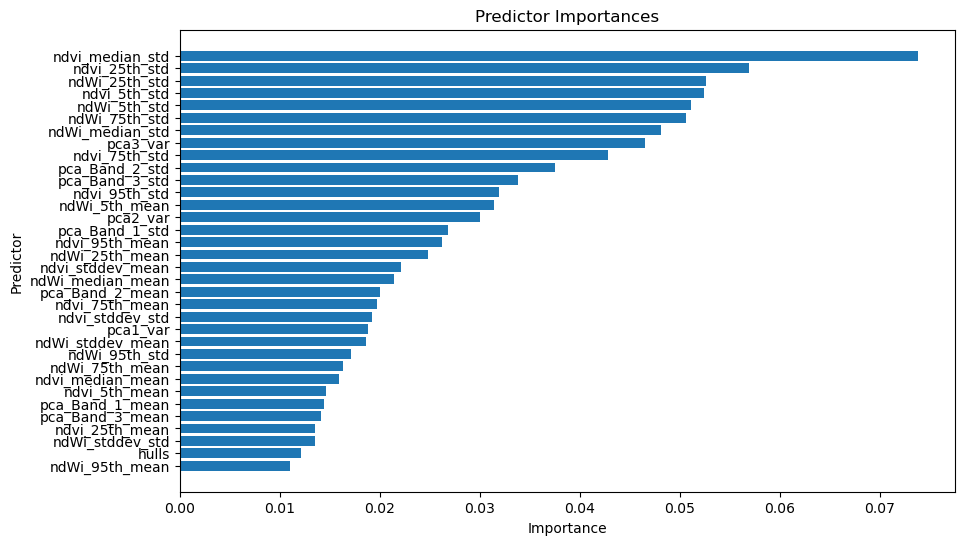

In [10]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

aoi = brigalow.to_crs(3577)

# Define predictors and target
predictors = colnames[:34]

# Creating a pipeline that includes scaling and the random forest classifier
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=random_state, n_estimators=800, n_jobs=-1, max_depth=10))
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(pipeline, x, y, cv=cv, scoring='accuracy')

# Fit the model on the entire dataset
pipeline.fit(x, y)

# Extracting feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
most_important_feature = predictors[feature_importances.argmax()]
importance_value = feature_importances.max()

# Sort feature importances from most to least
sorted_indices = feature_importances.argsort()[::-1]
sorted_predictors = [predictors[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Invert the sorted lists to have the most important features on top
sorted_predictors = sorted_predictors[::-1]
sorted_importances = sorted_importances[::-1]

# Print cross-validation scores, mean accuracy, and feature importances
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())
print("Most important feature:", most_important_feature)
print("Importance value:", importance_value)

# Plot predictor importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Predictor Importances')
plt.show()

# With spectral diversity
# Cross-validation scores: [0.87719298 0.92857143 0.875      0.82142857 0.89285714]
# Mean cross-validation accuracy: 0.8790100250626567
# Most important feature: pca_Band_2_std
# Importance value: 0.0747816717808225

# Without spectral diversity variables
# Cross-validation scores: [0.85964912 0.875      0.875      0.83928571 0.875     ]
# Mean cross-validation accuracy: 0.8647869674185464
# Most important feature: pca_Band_2_std
# Importance value: 0.10031766355085635

# Without spectral diversity variables and PCA band stds
# Cross-validation scores: [0.87719298 0.875      0.83928571 0.83928571 0.85714286]
# Mean cross-validation accuracy: 0.8575814536340852
# Most important feature: ndWi_25th_std
# Importance value: 0.10055163076400273


In [30]:
colnames = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean',
            'ndvi_median_mean', 'ndvi_stddev_mean',
            'ndvi_5th_mean', 'ndvi_25th_mean', 'ndvi_75th_mean', 
            'ndvi_95th_mean', 'ndvi_95th_std', 'ndWi_median_mean', 
           'ndWi_5th_mean',  'ndWi_25th_mean',  'ndWi_75th_mean',
             'ndWi_95th_mean', 'pca2_var', 'pca3_var', 'pca1_var', 'hulls', target_species]

print(len(colnames))

22


Optimising model
Best parameters: {'classifier__max_depth': 11, 'classifier__max_features': 17, 'classifier__min_samples_leaf': 17, 'classifier__min_samples_split': 18, 'classifier__n_estimators': 51}
Cross-validating model
CV Accuracy: 0.7066666666666668
CV Balanced Accuracy: 0.7067857142857144
CV F1 Score: 0.7033878921499154
Mean class CV AUC: 0.7895833333333333


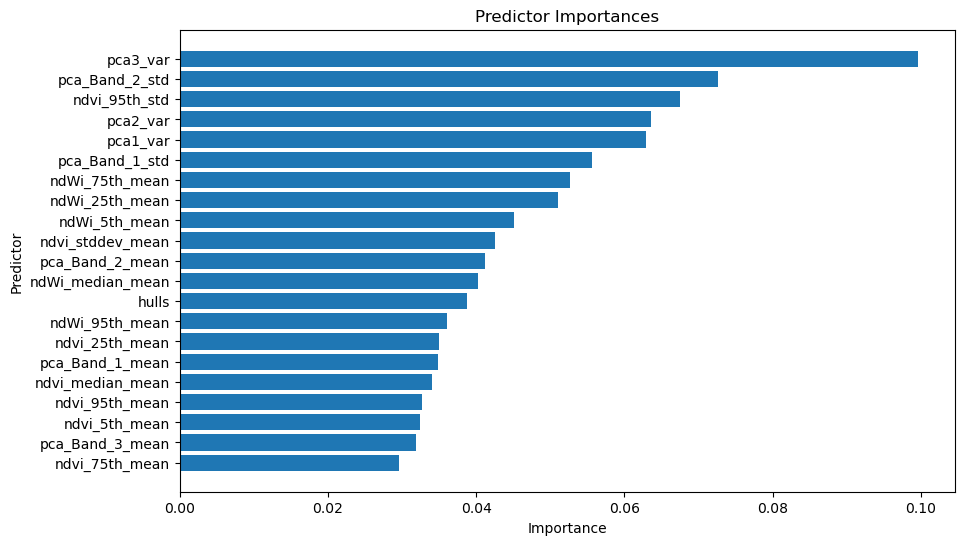

In [ ]:
# Make test/train datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

random_state = 42 # Set a random seed for reproducibility


colnames = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean',
            'pca_Band_3_std','ndvi_median_mean', 'ndvi_median_std', 'ndvi_stddev_mean', 'ndvi_stddev_std',
            'ndvi_5th_mean', 'ndvi_5th_std', 'ndvi_25th_mean', 'ndvi_25th_std', 'ndvi_75th_mean', 'ndvi_75th_std',
            'ndvi_95th_mean', 'ndvi_95th_std', 'ndWi_median_mean', 'ndWi_median_std', 'ndWi_stddev_mean',
            'ndWi_stddev_std', 'ndWi_5th_mean', 'ndWi_5th_std', 'ndWi_25th_mean', 'ndWi_25th_std', 'ndWi_75th_mean',
            'ndWi_75th_std', 'ndWi_95th_mean', 'ndWi_95th_std', 'pca2_var', 'pca3_var', 'pca1_var', 'hulls', target_species] # 'pca2_var', 'pca3_var', 'pca1_var', 'hulls' 'A_harpophylla'


predictors = colnames[:-1]

numpredictors = len(predictors)

varray = []

for cols in colnames:
    varray.append(rat.readColumn(RASTER_SEG, cols))
    
presAbs = np.array(varray).T

# remove no data rows
presAbs = presAbs[~(presAbs[:,numpredictors] == 9999)]

# shuffle the data
np.random.shuffle(presAbs)

# Get the x and y data with only spectral predictors
x = presAbs[:,0:numpredictors]
y = presAbs[:,numpredictors]

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for the random search
params = {
    'classifier__n_estimators': randint(50, 1000),
    'classifier__max_features': randint(2, 50),
    'classifier__max_depth': randint(5, 25),
    'classifier__min_samples_split': randint(2,20),
    'classifier__min_samples_leaf': randint(2,20),
}

print("Optimising model")
rand_search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=3, n_jobs=-1, random_state=42)

# Fit the model
rand_search.fit(x, y)

print(f"Best parameters: {rand_search.best_params_}")

# Use the best pipeline from the random search
best_pipeline = rand_search.best_estimator_

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba', average='weighted')
}

print("Cross-validating model")

# Perform cross-validation
# Create the StratifiedKFold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Use the cross_validate function
cv_results = cross_validate(best_pipeline, x, y, scoring=scoring, cv=cv)

# Print cross-validation results
print('CV Accuracy:', np.mean(cv_results['test_accuracy']))
print('CV Balanced Accuracy:', np.mean(cv_results['test_balanced_accuracy']))
print('CV F1 Score:', np.mean(cv_results['test_f1']))
print('Mean class CV AUC:', np.nanmean(cv_results['test_roc_auc']))


# Fit the model on the entire dataset
pipeline.fit(x, y)

# Extracting feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
most_important_feature = predictors[feature_importances.argmax()]
importance_value = feature_importances.max()

# Sort feature importances from most to least
sorted_indices = feature_importances.argsort()[::-1]
sorted_predictors = [predictors[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Invert the sorted lists to have the most important features on top
sorted_predictors = sorted_predictors[::-1]
sorted_importances = sorted_importances[::-1]

# Plot predictor importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Predictor Importances')
plt.show()

# with spectral variation
# Best parameters: {'classifier__n_estimators': 166, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 20}
# Cross-validating model
# CV Accuracy: 0.8634278002699055
# CV Balanced Accuracy: 0.6212527056277056
# CV F1 Score: 0.8330085472626108
# Mean class CV AUC: 0.8090773809523808

# without spectral variation
# Best parameters: {'classifier__n_estimators': 118, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 3, 'classifier__max_features': None, 'classifier__max_depth': 15}
# Cross-validating model
# CV Accuracy: 0.8531135531135531
# CV Balanced Accuracy: 0.6300000000000001
# CV F1 Score: 0.8294599900319207
# Mean class CV AUC: 0.8018145956607494


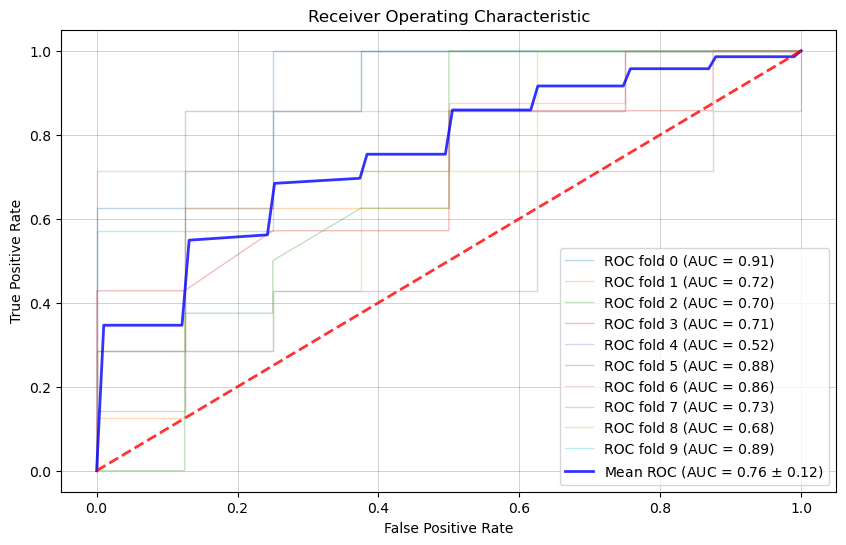

In [32]:
# Make a ROC Curve
# Create stratified k-fold cross-validator
kf = StratifiedKFold(n_splits=10)

# Initialize variables to store results
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_index, test_index) in enumerate(kf.split(x, y)):
    # Fit the model
    pipeline.fit(x[train_index], y[train_index])
    
    # Predict probabilities
    y_pred_proba = pipeline.predict_proba(x[test_index])[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y[test_index], y_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate TPR at mean FPR points
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot the ROC curve for current fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

# Calculate mean TPR and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

# Plot chance level
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Customize plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Add a transparent grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
plt.show()

In [14]:
# Make predictions on the full dataset
# Getting probabilities for all classes

varray = []

for cols in colnames:
    varray.append(rat.readColumn(RASTER_SEG, cols))
    
presAbs = np.array(varray).T


pred_vars = presAbs[:,0:34]

probabilities = pipeline.predict_proba(pred_vars)

# Get the probabilities for class 1
class1_probabilities = probabilities[:, 1] * 100

# replace first row value with 255
class1_probabilities[0] = 255

# Write the probabilities to the RAT
rat.writeColumn(RASTER_SEG, f'{target_species}_prob', class1_probabilities.astype(np.uint8))



In [15]:
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', f'{target_species}_prob.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
setattr(otherargs, 'prob', 
            np.array(rat.readColumn(infiles.image, f'{target_species}_prob')).astype(np.uint8))

otherargs.noData = 255
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(255)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

# conc = applier.ConcurrencyStyle(numReadWorkers=3,
#                                 numComputeWorkers=2,
#                                 computeWorkerKind="CW_THREADS",
#                                 readBufferPopTimeout=120,
#                                 computeBufferPopTimeout=120
#                                 )
# controls.setConcurrencyStyle(conc)

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = getattr(otherargs, 'prob')[data]
    outputs.var = rgb.reshape(inputs.image.shape).astype(np.uint8)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation
